In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.optimize
import matplotlib.pyplot as plt

# 1. Read the list of tickers from a csv file
tickers_file = 'TechTickers-2.csv'
tickers = pd.read_csv(tickers_file, header=None).iloc[:, 0].tolist()
tickers_str = " ".join(tickers)

# Download stock data
try:
    start_date = '2013-01-01'
    end_date = '2022-01-01'
    stock_data = yf.download(tickers_str, start=start_date, end=end_date, auto_adjust=False)
except Exception as e:
    print(f"An error occurred while downloading data: {e}")
    print("Attempting to remove problematic tickers...")
    if 'INTC' in tickers:
        tickers.remove('INTC')
    tickers_str = " ".join(tickers)
    stock_data = yf.download(tickers_str, start=start_date, end=end_date, auto_adjust=False)


[*********************100%***********************]  67 of 67 completed


In [21]:

stock_data.head()

Price       Adj Close                                                         \
Ticker           AAPL        ACN       ADBE        ADI       ADSK       AKAM   
Date                                                                           
2013-01-02  16.628305  54.944656  38.340000  33.284348  36.939999  42.160000   
2013-01-03  16.418423  54.745750  37.750000  32.747261  36.369999  40.950001   
2013-01-04  15.961093  55.048103  38.130001  32.164795  36.360001  40.430000   
2013-01-07  15.867211  54.809391  37.939999  32.263130  36.090000  40.770000   
2013-01-08  15.909909  55.127651  38.139999  31.930279  36.299999  40.139999   

Price                                            ...   Volume           \
Ticker          AMAT   AMD       ANSS       APH  ...      TEL      TER   
Date                                             ...                     
2013-01-02  9.890345  2.53  70.050003  7.556694  ...  1738900  3255700   
2013-01-03  9.865284  2.49  69.769997  7.460125  ...  1342600  2177200   
2013-01-04  9.865284  2.59  70.500000  7.430159  ...  1640100  1904500   
2013-01-07  9.748338  2.67  70.489998  7.440145  ...  1559000  1696600   
2013-01-08  9.614685  2.67  71.080002  7.402409  ...  1072400  1477900   

Price                                                                      \
Ticker           TSM       TXN     TYL      UI     VRSN     WDAY      WDC   
Date                                                                        
2013-01-02  10226100  13357500  154600  177400  3197900  1103500  5855995   
2013-01-03  13148600   8832500   97800   99500  2608400   433800  3940291   
2013-01-04   7464200   7606600  105300   73600  3864100   547800  3619067   
2013-01-07   9429900   7392900  103800  121700  2950000   348700  4324226   
2013-01-08   8112900   6904200   91000  153700  2926800   400100  5028194   

Price               
Ticker        ZBRA  
Date                
2013-01-02  213800  
2013-01-03   99900  
2013-01-04  146000  
2013-01-07   90600  
2013-01-08  112600  

[5 rows x 402 columns]

In [32]:

# Use adjusted closing prices for return calculations
adj_close_prices = stock_data['Adj Close']

# Calculate log returns
daily_returns = (adj_close_prices / adj_close_prices.shift(1) - 1).dropna()
# daily_returns = adj_close_prices.pct_change().dropna()

# Annualize assuming 250 days in a year
ANNUAL_DAYS = 250
mu_annual = daily_returns.mean() * ANNUAL_DAYS
Sigma_annual = daily_returns.cov() * ANNUAL_DAYS
num_assets = len(tickers)


In [33]:
# --- Question 1. (a) ---
print("--- Question 1. (a) ---")
print("Estimated vector of mean returns (annualized):")
print(mu_annual)
print("\nEstimated covariance matrix (annualized):")
print(Sigma_annual)
print("\n" + "="*50 + "\n")



--- Question 1. (a) ---
Estimated vector of mean returns (annualized):
Ticker
AAPL    0.298833
ACN     0.242179
ADBE    0.340781
ADI     0.218099
ADSK    0.282813
          ...   
UI      0.467413
VRSN    0.234250
WDAY    0.253765
WDC     0.159062
ZBRA    0.362211
Length: 67, dtype: float64

Estimated covariance matrix (annualized):
Ticker      AAPL       ACN      ADBE       ADI      ADSK      AKAM      AMAT  \
Ticker                                                                         
AAPL    0.079009  0.030551  0.043284  0.042107  0.043768  0.027524  0.051571   
ACN     0.030551  0.051445  0.036998  0.035026  0.041042  0.028422  0.041704   
ADBE    0.043284  0.036998  0.087065  0.046594  0.063060  0.038253  0.056320   
ADI     0.042107  0.035026  0.046594  0.083632  0.051810  0.030631  0.074157   
ADSK    0.043768  0.041042  0.063060  0.051810  0.117526  0.039293  0.065250   
...          ...       ...       ...       ...       ...       ...       ...   
UI      0.035961  0.03498

In [37]:
# --- Question 1. (b) ---
print("--- Question 1. (b) ---")
# Objective function: minimize variance
def portfolio_variance(weights):
    return weights.T @ Sigma_annual.to_numpy() @ weights

# Constraints: sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights between 0 and 1 (no short-selling)
# bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess
initial_weights = np.array([1/num_assets] * num_assets)

# Optimize for minimal-variance portfolio
min_var_opt = scipy.optimize.minimize(
    fun=portfolio_variance,
    x0=initial_weights,
    method='SLSQP',
    constraints=constraints,
    # bounds=bounds
)

min_var_weights = min_var_opt.x
print("Weights of the minimal-variance portfolio:")
for ticker, weight in zip(tickers, min_var_weights):
    print(f"{ticker}: {weight:.4f}")

min_var_std = np.sqrt(portfolio_variance(min_var_weights))
min_var_mean = np.dot(min_var_weights, mu_annual.to_numpy())
print(f"\nMinimal-variance portfolio standard deviation: {min_var_std:.4f}")
print(f"Minimal-variance portfolio mean return: {min_var_mean:.4f}")
print("\n" + "="*50 + "\n")


--- Question 1. (b) ---
Weights of the minimal-variance portfolio:
AAPL: 0.0589
MSFT: -0.0392
TSM: -0.0285
INTC: 0.0498
CSCO: -0.0557
ORCL: 0.0143
SAP: -0.0009
ADBE: -0.0129
CRM: -0.0303
NVDA: 0.0740
ACN: 0.0457
ASML: 0.0278
AVGO: -0.0103
TXN: 0.0870
IBM: -0.0167
QCOM: 0.1860
FIS: -0.0128
INTU: 0.0096
MU: -0.0465
AMAT: -0.0321
AMD: 0.0279
NOW: -0.0812
ADI: 0.0127
LRCX: -0.0299
INFY: 0.1069
ADSK: -0.0810
WDAY: 0.0673
NXPI: 0.0005
CTSH: 0.1046
TEL: 0.0510
APH: 0.0146
HPQ: -0.0691
ERIC: 0.0434
MSI: 0.1824
KLAC: -0.0200
MCHP: 0.0123
STM: -0.0827
VRSN: -0.0415
GLW: 0.0265
PANW: -0.0147
GIB: 0.1043
ANSS: -0.0070
SNPS: -0.0393
WDC: -0.0128
SWKS: -0.0381
CDNS: -0.0116
FTNT: 0.0112
GRMN: 0.0591
MRVL: 0.0398
CHKP: 0.0372
STX: 0.0463
SSNC: 0.1172
AKAM: -0.0208
NTAP: -0.0560
BR: 0.0257
IT: -0.0587
LDOS: 0.0224
ZBRA: 0.0416
TDY: -0.0124
EPAM: 0.0962
OTEX: 0.0638
TYL: 0.0809
UI: -0.0171
TER: 0.0774
FICO: 0.0071
JKHY: -0.0271
ASX: -0.0265

Minimal-variance portfolio standard deviation: 0.1376
Minimal

<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1325231708.py:36: SyntaxWarning: invalid escape sequence '\g'
  plt.title('Optimal Mean-Variance Portfolio Weights ($\gamma=2$)')


--- Question 1. (c) ---
Weights of the optimal mean-variance portfolio (gamma=2):
AAPL: 0.1454
MSFT: 0.5924
TSM: 0.2723
INTC: -0.5848
CSCO: -0.1177
ORCL: -0.2313
SAP: -0.0368
ADBE: 0.1639
CRM: -0.6972
NVDA: 0.0427
ACN: 0.1171
ASML: -0.3183
AVGO: 0.7187
TXN: 0.7773
IBM: 0.0942
QCOM: -0.5442
FIS: -0.3568
INTU: -0.0854
MU: -0.5303
AMAT: 0.5405
AMD: -0.3502
NOW: -0.1919
ADI: -0.1418
LRCX: 0.2122
INFY: 0.0250
ADSK: -0.0164
WDAY: -0.0357
NXPI: 0.2738
CTSH: -0.9352
TEL: 0.3767
APH: -0.3786
HPQ: 0.0835
ERIC: 0.0847
MSI: 0.1288
KLAC: 0.1161
MCHP: 0.1779
STM: 0.3642
VRSN: -0.2401
GLW: 0.1778
PANW: 0.7543
GIB: 0.1464
ANSS: 0.1679
SNPS: 0.2340
WDC: -0.0637
SWKS: 0.4445
CDNS: 0.0174
FTNT: -0.0798
GRMN: -0.0468
MRVL: 0.1363
CHKP: -0.4012
STX: -0.6750
SSNC: 0.1703
AKAM: 0.0949
NTAP: 0.0647
BR: 0.3207
IT: -0.2201
LDOS: 0.3252
ZBRA: 0.0609
TDY: -0.1925
EPAM: 0.4246
OTEX: -0.1227
TYL: 0.2320
UI: 0.2841
TER: -0.0951
FICO: -0.4060
JKHY: -0.5368
ASX: 0.2690

Optimal mean-variance portfolio mean return: 1.7

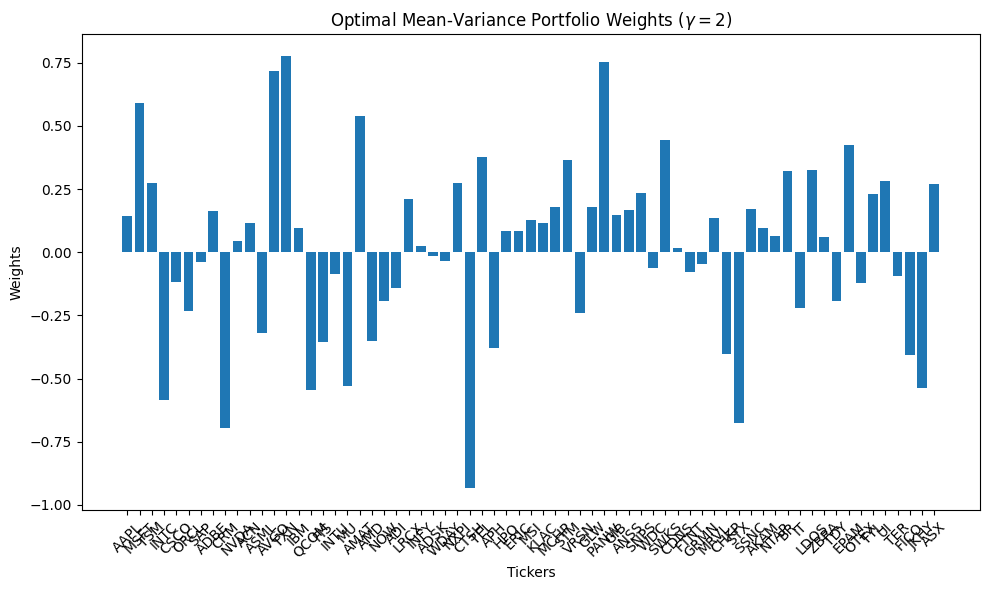

<Figure size 640x480 with 0 Axes>

In [44]:

# --- Question 1. (c) ---
print("--- Question 1. (c) ---")
gamma = 2

# Objective function: maximize utility (mean - 0.5 * gamma * variance)
def utility_objective(weights, mu, Sigma, gamma):
    mean_return = np.dot(weights, mu)
    variance = weights.T @ Sigma.to_numpy() @ weights
    return -(mean_return - gamma * variance)

# Optimize for optimal mean-variance portfolio with gamma=2
opt_mv_opt = scipy.optimize.minimize(
    fun=utility_objective,
    x0=initial_weights,
    args=(mu_annual, Sigma_annual, gamma),
    method='SLSQP',
    constraints=constraints,
    # bounds=bounds
)

opt_mv_weights = opt_mv_opt.x
print("Weights of the optimal mean-variance portfolio (gamma=2):")
for ticker, weight in zip(tickers, opt_mv_weights):
    print(f"{ticker}: {weight:.4f}")

# Calculate and print mean and standard deviation of the resulting portfolio
opt_mv_mean = np.dot(opt_mv_weights, mu_annual.to_numpy())
opt_mv_std = np.sqrt(portfolio_variance(opt_mv_weights))

print(f"\nOptimal mean-variance portfolio mean return: {opt_mv_mean:.4f}")
print(f"Optimal mean-variance portfolio standard deviation: {opt_mv_std:.4f}")

# Plotting the portfolio weights on a graph
plt.figure(figsize=(10, 6))
plt.bar(tickers, opt_mv_weights)
plt.title('Optimal Mean-Variance Portfolio Weights ($\gamma=2$)')
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('optimal_mv_weights_gamma2.png')
plt.clf()
print("\n" + "="*50 + "\n")


--- Question 1. (d) ---
Weights of the optimal mean-variance portfolio (Robust Setting):
AAPL: 0.0002
MSFT: 0.0000
TSM: 0.0004
INTC: 0.0002
CSCO: 0.0001
ORCL: 0.0000
SAP: -0.0000
ADBE: 0.0002
CRM: 0.0001
NVDA: 0.0011
ACN: 0.0001
ASML: -0.0001
AVGO: 0.0240
TXN: 0.4435
IBM: 0.0007
QCOM: 0.0000
FIS: 0.0000
INTU: 0.0001
MU: 0.0000
AMAT: 0.0716
AMD: -0.0001
NOW: -0.0000
ADI: 0.0000
LRCX: 0.0003
INFY: 0.0001
ADSK: -0.0000
WDAY: 0.0001
NXPI: 0.0002
CTSH: 0.0000
TEL: 0.0002
APH: 0.0000
HPQ: 0.0007
ERIC: 0.0000
MSI: 0.0001
KLAC: 0.0004
MCHP: 0.0000
STM: 0.0002
VRSN: 0.0000
GLW: 0.0001
PANW: 0.2083
GIB: 0.0007
ANSS: 0.0001
SNPS: 0.0002
WDC: 0.0000
SWKS: 0.1887
CDNS: 0.0000
FTNT: 0.0000
GRMN: 0.0000
MRVL: 0.0001
CHKP: 0.0000
STX: 0.0000
SSNC: 0.0341
AKAM: -0.0000
NTAP: -0.0001
BR: 0.0000
IT: 0.0000
LDOS: 0.0000
ZBRA: -0.0000
TDY: 0.0001
EPAM: 0.0004
OTEX: -0.0000
TYL: 0.0224
UI: 0.0002
TER: 0.0003
FICO: -0.0000
JKHY: -0.0000
ASX: 0.0002

Comparison with Part (c) portfolio:
Part (c) Std Dev: 0.662

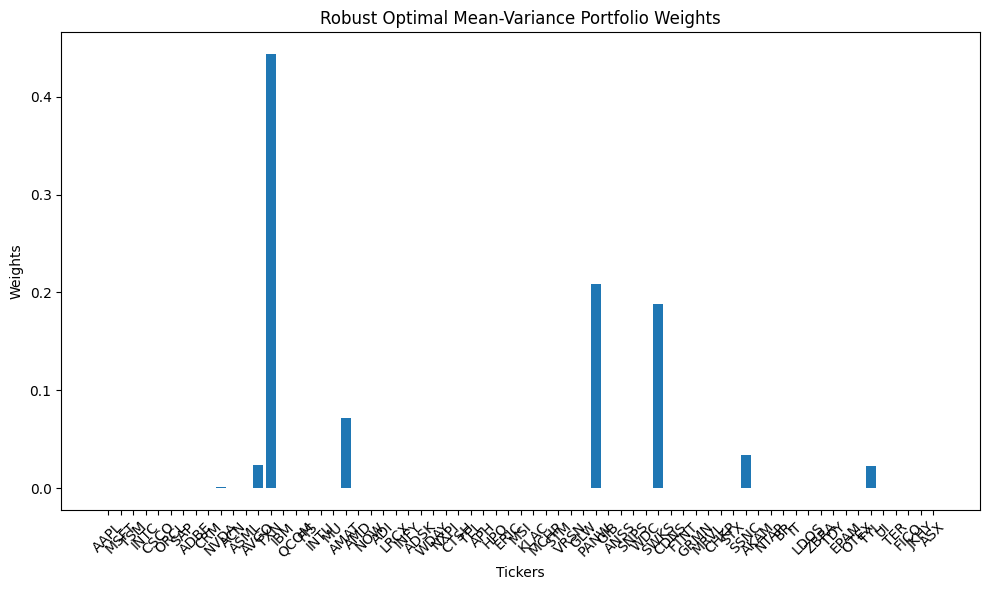

<Figure size 640x480 with 0 Axes>

In [48]:

# --- Question 1. (d) ---
print("--- Question 1. (d) ---")
# Robust setting: worst-case mean returns are within one std dev of sample means
mu_worst_case = mu_annual - np.sqrt(np.diag(Sigma_annual))

# Objective function for the robust optimal portfolio
def robust_utility_objective(weights, mu_worst, Sigma, gamma):
    mean_return = np.dot(weights, mu_annual) - np.dot(np.abs(weights), np.sqrt(np.diag(Sigma_annual)))
    variance = weights.T @ Sigma.to_numpy() @ weights
    return -(mean_return - gamma * variance)

# Optimize for robust optimal mean-variance portfolio with gamma=2
robust_opt = scipy.optimize.minimize(
    fun=robust_utility_objective,
    x0=initial_weights,
    args=(mu_worst_case, Sigma_annual, gamma),
    method='SLSQP',
    constraints=constraints,
    # bounds=bounds
)

robust_weights = robust_opt.x
print("Weights of the optimal mean-variance portfolio (Robust Setting):")
for ticker, weight in zip(tickers, robust_weights):
    print(f"{ticker}: {weight:.4f}")

# Calculate metrics for comparison
robust_std = np.sqrt(portfolio_variance(robust_weights))
robust_mean_worst = np.dot(robust_weights, mu_worst_case.to_numpy())
robust_mean_best = np.dot(robust_weights, (mu_annual + np.sqrt(np.diag(Sigma_annual))).to_numpy())
robust_mean_sample = np.dot(robust_weights, mu_annual.to_numpy())

print("\nComparison with Part (c) portfolio:")
print(f"Part (c) Std Dev: {opt_mv_std:.4f}")
print(f"Part (d) Std Dev: {robust_std:.4f}")
print("\nPart (d) Worst-case mean return (based on one std dev below sample mean):")
print(f"  Worst-case mean return: {robust_mean_worst:.4f}")
print(f"  Best-case mean return (based on one std dev above sample mean): {robust_mean_best:.4f}")
print(f"  Sample mean return: {robust_mean_sample:.4f}")

# Plotting the weights of the robust optimal portfolio
plt.figure(figsize=(10, 6))
plt.bar(tickers, robust_weights)
plt.title('Robust Optimal Mean-Variance Portfolio Weights')
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('robust_optimal_mv_weights.png')
plt.clf()
print("\n" + "="*50 + "\n")



--- Question 1. (e) ---


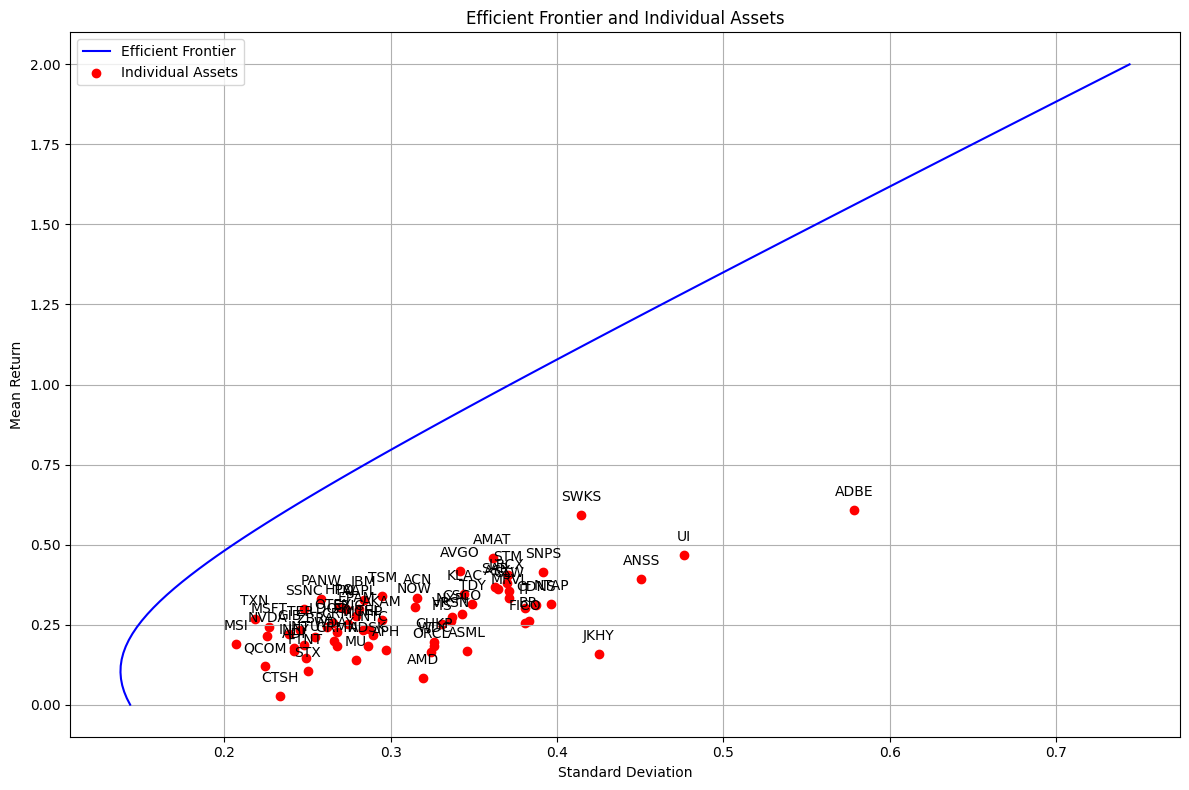

In [49]:
# --- Question 1. (e) ---
print("--- Question 1. (e) ---")
# Compute the efficient frontier
target_returns = np.linspace(0, 2, 100)
efficient_frontier_stds = []
efficient_frontier_returns = []

for target_return in target_returns:
    # Objective: minimize variance
    # Constraints: sum of weights is 1, and portfolio mean equals target mean
    frontier_constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, mu_annual.to_numpy()) - target_return}
    )

    result = scipy.optimize.minimize(
        fun=portfolio_variance,
        x0=initial_weights,
        method='SLSQP',
        constraints=frontier_constraints,
        # bounds=bounds
    )

    if result.success:
        efficient_frontier_stds.append(np.sqrt(result.fun))
        efficient_frontier_returns.append(target_return)

# Plotting the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(efficient_frontier_stds, efficient_frontier_returns, 'b-', label='Efficient Frontier')
plt.title('Efficient Frontier and Individual Assets')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Return')

# Plotting individual assets
asset_stds = np.sqrt(np.diag(Sigma_annual))
asset_means = mu_annual.to_numpy()
plt.scatter(asset_stds, asset_means, color='red', marker='o', label='Individual Assets')
for i, ticker in enumerate(tickers):
    plt.annotate(ticker, (asset_stds[i], asset_means[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('efficient_frontier.png')